In [85]:
import time
nb_start_time = time.time()

In [86]:
# import libraries
import json
import sys
import os
from tqdm import tqdm
from tqdm import trange
import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import TensorDataset, DataLoader

sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

np.random.seed(42)

In [87]:
# import scripts

import config as config
from scripts.matching import match_behaviors
import src.data_prep.create_segments_and_metadata as create_segments_and_metadata
import src.data_prep.data_prep_utils as data_prep_utils
import src.data_prep.create_matched_data_objects as create_matched_data_objects
import src.utils.data as utils_data
import src.utils.io as utils_io
import src.utils.plot as utils_plot
from src.methods.prediction_model import create_dynamic_conv_model
from src.utils.train import (training_loop,
                             multi_label_eval_loop,
                             train_run)
from src.utils.plot import(multi_label_predictions,
                            plot_signal_and_online_predictions)
from src.methods.online_predictions import (online_score_evaluation,
                                            online_smoothening)
from src.utils.simulations import (plot_simulated_day,
                                    simulate_fourier_signal,
                                    generate_acc_data,
                                    simulate_axis_signal,
                                    simulate_markov_acc_day)
from dataclasses import dataclass

In [88]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates


mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 25
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

## Creating simulated data

We create simulated acceleration and annotations data. We consider five behavioral categories of interest: 
 - Eating
 - Resting
 - Walking
 - Running
 - Grooming

Let the tri-axial acceleration at time $t$ for behavior $a$ be denoted by $(X^a(t), Y^a(t), Z^a(t))$. The acceleration signal for each behavior and each direction is simulated using the fourier breakdown of the signal into 5 sets of frequencies, amplitudes, and phase information. Let the (frequency, amplitude, phase) set for $a$ behavior along $X$ axis be denoted by $$(f_{X, i}^a, A_{X,i}^a, \phi_{X, i}^a)_{i=[5]}$$
The sets are defined similarly for other axes and behaviors. Additionally, Gaussian noise with variuance $\sigma_X^2$ (resp. $\sigma_Y^2$ and $\sigma_Z^2$) for X (resp. Y and Z) axisis added to the signal. Therefore, the data is simulated as
$$X^a(t) = \sum_{i=1}^5 A_{X, i}^a \sin(2\pi f_{X,i}^a t + \phi_{X, i}^a) + \mathcal{N}(0, \sigma_X^2).$$


In [89]:
test_root_dir = config.TEST_ROOT_DIR
os.makedirs(test_root_dir, exist_ok=True)

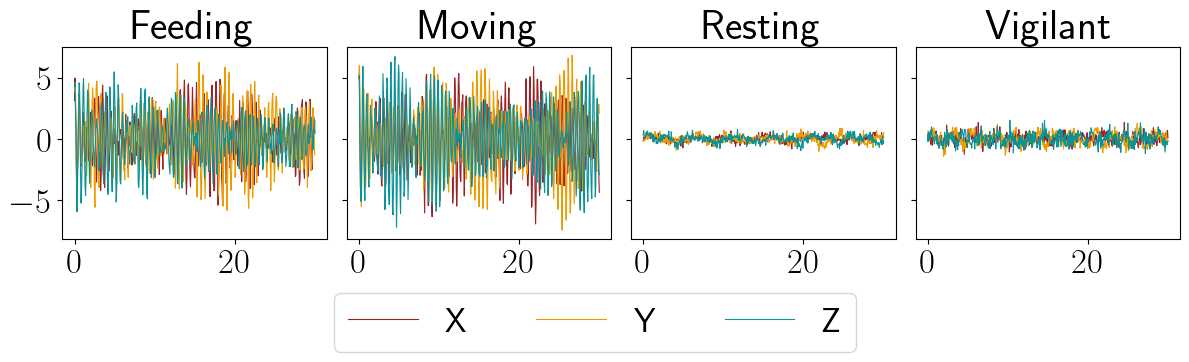

In [90]:
t = np.linspace(0, 30, 30*config.SAMPLING_RATE)
data_constants = config.SIMULATION_CONSTANTS
colors = ['#9b2226', '#ee9b00', '#0a9396']
fig, axs = plt.subplots(1, len(config.SIM_BEHAVIORS), figsize=(3*len(config.SIM_BEHAVIORS),3), sharey=True)
for i, observed_behavior in enumerate(config.SIM_BEHAVIORS):
    for j, axis in enumerate(['X', 'Y', 'Z']):
        f, A, phi, sigma = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == axis), ['f', 'A', 'phi', 'sigma']].values[0]
        signal = simulate_axis_signal(f, A, phi, sigma, len(t))

        if i == 0:
            axs[i].plot(t, signal, label=axis, linewidth=0.8, color=colors[j])
        else:
            axs[i].plot(t, signal, linewidth=0.8, color=colors[j])

    axs[i].set_title(observed_behavior)

fig.legend(loc="lower center", ncol=3, bbox_to_anchor=(0.5,-0.25))
plt.tight_layout()
plt.savefig(os.path.join(test_root_dir, 'sim_train_signal.pdf'))
plt.show()



## Result 1: Class Imbalance

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


| Behavior | Probability of occurence |
|----------|--------------------------|
| Feeding  |  0.05   |
| Moving   | 0.2 |
| Resting  | 0.4 |
| Vigilant | 0.35 |

In [91]:
# define paths

# Create directories and generate acceleration data
results_dir = os.path.join(config.TEST_ROOT_DIR, "class_imbalance")
os.makedirs(results_dir, exist_ok=True)

training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

In [92]:
class_dist = dict(zip(config.SIM_BEHAVIORS, [0.05, 0.2, 0.4, 0.35]))

window_length = int(30.0 * config.SAMPLING_RATE)

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)

LabelEncoder()

In [101]:
data_constants = [
    
    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.4, 1.5, 1.7), (1.1, 1.2, 1.3), (0.2, 0.7, 1.2), 0.5),
    ("Feeding", "Y", (1.3, 1.5, 1.6), (1.1, 1.2, 1.4), (0.3, 0.8, 1.3), 0.6),
    ("Feeding", "Z", (1.5, 1.5, 1.8), (1.1, 1.2, 1.5), (0.4, 0.9, 1.4), 0.5),

    # Moving — bring down the amplitude and overlap with Moving
    ("Moving", "X", (1.4, 1.5, 1.7), (1.3, 1.5, 1.5), (0.2, 0.7, 1.2), 0.5),
    ("Moving", "Y", (1.3, 1.5, 1.6), (1.4, 1.5, 1.6), (0.3, 0.8, 1.3), 0.6),
    ("Moving", "Z", (1.5, 1.5, 1.8), (1.3, 1.4, 1.7), (0.4, 0.9, 1.4), 0.5),

    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.15),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),

    # Vigilant — make it slightly jittery to overlap with Vigilant
    ("Vigilant", "X", (0.3, 0.4, 0.5), (0.2, 0.2, 0.15), (0.0, 0.1, 0.2), 0.15),
    ("Vigilant", "Y", (0.3, 0.4, 0.5), (0.2, 0.2, 0.15), (0.0, 0.1, 0.2), 0.2),
    ("Vigilant", "Z", (0.3, 0.4, 0.5), (0.2, 0.2, 0.15), (0.0, 0.1, 0.2), 0.2),
]

data_constants = pd.DataFrame(data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])

In [104]:

@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=5, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=200, alpha=0.05, verbose=0
)

args.experiment_name = 'test_interyear'
args.theta= 0.8

train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles(args.experiment_name)

In [ ]:
# train the CNN model on a fixed train set 

test_data_constants = get_test_data_constants(train_data_constants, 0.0)

# train and test set
X_train, y_train = generate_dataset(train_data_constants, train_class_dist, window_length, n_train, wrong_behavior=False, wrong_behavior_prob=0.4)
X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(y_train))

train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                        num_conv_layers=args.n_CNNlayers, 
                                        base_channels=args.n_channels, 
                                        kernel_size=args.kernel_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

#### Training
train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
model = train_obj['model']
training_stats = train_obj['training_stats']

model_dir = training_results_dir
os.makedirs(model_dir, exist_ok=True)

torch.save(model, os.path.join(model_dir, 'model.pt'))
json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
with open(json_training_stats_file, 'w') as f:
    json.dump(training_stats, f)

# save true and predicted validation classes along with val metadata
np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])


In [103]:
n = 6000
X, y = generate_dataset(data_constants, class_dist, window_length, n, wrong_behavior=False, wrong_behavior_prob=0.1)
print(np.unique(y, return_counts=True))
y = label_encoder.transform(y)

# First split: train_val vs test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss1.split(np.zeros(n), y))

X_train_val, y_train_val = X[train_val_idx], y[train_val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Second split: train vs val (e.g., 80% train, 20% val of train_val set)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 of total
train_idx, val_idx = next(sss2.split(np.zeros(len(y_train_val)), y_train_val))

X_train, y_train = X_train_val[train_idx], y_train_val[train_idx]
X_val, y_val = X_train_val[val_idx], y_train_val[val_idx]

print(f"{'X train shape':<10} {X_train.shape} {'X val shape':<10} {X_val.shape} {'X test shape':<10} {X_test.shape}")

n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(y_train))
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")


(array(['Feeding', 'Moving', 'Resting', 'Vigilant'], dtype='<U8'), array([ 285, 1161, 2443, 2111]))
X train shape (3600, 3, 480) X val shape (1200, 3, 480) X test shape (1200, 3, 480)


In [ ]:

thetas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for i, theta in enumerate(thetas):

    args.theta = theta
    train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)


    # Define the sequential model
    model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                            num_conv_layers=args.n_CNNlayers, 
                                            base_channels=args.n_channels, 
                                            kernel_size=args.kernel_size).to(device)

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

    #### Training
    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
    model = train_obj['model']
    training_stats = train_obj['training_stats']

    model_dir = os.path.join(training_results_dir, f"theta{theta}")
    os.makedirs(model_dir, exist_ok=True)

    torch.save(model, os.path.join(model_dir, 'model.pt'))
    json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'test_true_classes.npy'),  train_obj['test_true_classes'])
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  train_obj['test_predictions'])

In [8]:
# load metadata and annotations
metadata = pd.read_csv(metadata_path)

# load the saved matched data objects 
acc_summary = pd.read_csv(matched_summary_path)
acc_data = pd.read_csv(matched_data_path)
acc_data_metadata = pd.read_csv(matched_metadata_path)

In [10]:
start = time.time()
X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, _ = utils_data.setup_data_objects(metadata=metadata, 
                                                                                                    all_annotations=annotations_df, 
                                                                                                    collapse_behavior_mapping={}, 
                                                                                                    behaviors=config.SIM_BEHAVIORS, 
                                                                                                    args=args, 
                                                                                                    reuse_behaviors=config.SIM_BEHAVIORS,
                                                                                                    acc_data_path=matched_data_path,
                                                                                                    acc_metadata_path=matched_metadata_path
                                                                                                    )
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))

print("Train Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1]))
print("")

time_diff = time.time() - start

print("")
print(f'Creating data objects takes {time_diff:.2f} seconds.')
print("")
print("Shape of dataframes")
print("==========================")
print(f"{'Set':<8} {'X':<15} {'Y':<10} {'Z':<15}")
print(f"{'Train:':<8} {str(X_train.shape):<15} {str(y_train.shape):<10} {str(z_train.shape):<15}")
print(f"{'Val:':<8} {str(X_val.shape):<15} {str(y_val.shape):<10} {str(z_val.shape):<15}")
print(f"{'Test:':<8} {str(X_test.shape):<15} {str(y_test.shape):<10} {str(z_test.shape):<15}")

Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 983
Before overlap, 
no. of train observations: 983, no. of test observations: 983
Overlapping indices of shape = (983,)
After removing overlaps, 
no. of train observations: 786, no. of test observations: 197

Matching annotations to acceleration snippets takes 25.003419 seconds


/home/medhaaga/AWD-Biologging/notebooks/../src/utils/data.py:318: UserWarning: train and test filters overlap
  warnings.warn("train and test filters overlap", UserWarning)


Creating fixed-duration windows takes 4.938071 seconds.

Time series duration window = 30.0
Train Class distribution
      0
0   118
1   466
2  1420
3  1071


Creating data objects takes 30.14 seconds.

Shape of dataframes
Set      X               Y          Z              
Train:   (3075, 3, 480)  (3075,)    (3075, 7)      
Val:     (769, 3, 480)   (769,)     (769, 7)       
Test:    (999, 3, 480)   (999,)     (999, 7)       


In [11]:
def plot_raw_time_series(X, y, save_path=None):
    """
    Plot raw time series data for each unique class in y.

    Parameters:
    - X (np.ndarray): 3D array of time series data with shape (n_samples, n_channels, n_time_steps).
    - y (np.ndarray): Array of class labels corresponding to each sample in X.
    """

    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    fig, axs = plt.subplots(1, n_classes, figsize=(4 * n_classes, 4), sharex=True, sharey=True)
    if n_classes == 1:
        axs = [axs]

    custom_palette = sns.color_palette("husl", 3)
    handles = []
    labels = []

    for j, cls in enumerate(unique_classes):
        i = np.random.choice(np.where(y == cls)[0])
        time = np.linspace(0, X.shape[2] / 16, X.shape[2])

        # Plot each channel with corresponding colors
        for k, label in enumerate(['X', 'Y', 'Z']):
            line, = axs[j].plot(time, X[i, k, :], label=label, color=custom_palette[k], linewidth=0.8)
            if j == 0:  # Collect handles and labels only from the first subplot
                handles.append(line)
                labels.append(label)

        # Set title for the subplot
        axs[j].set_title(f'{cls}')
        axs[j].set_xlabel('Time (s)')

    axs[0].set_ylabel('Amplitude (g)')
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.15))

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

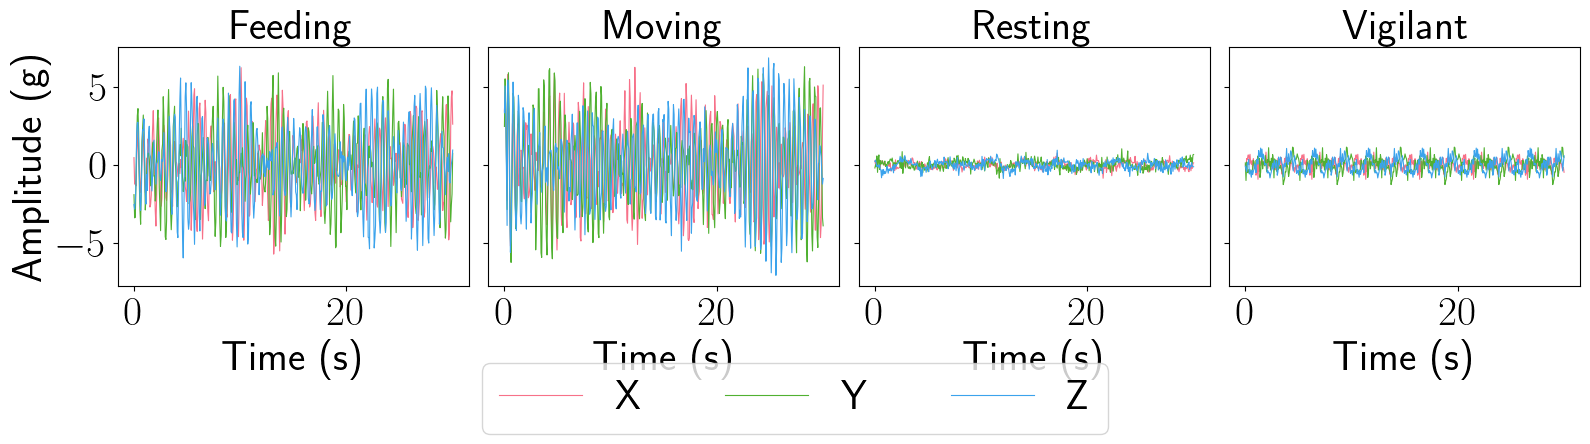

In [12]:
## fit a label encoder

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)
plot_raw_time_series(X_test, label_encoder.inverse_transform(y_test))

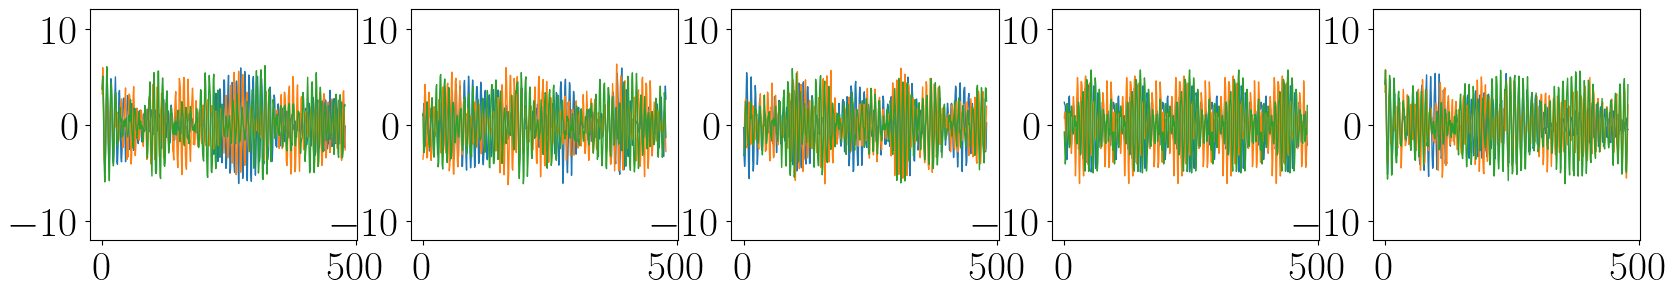

In [13]:
_, counts = np.unique(y_test, return_counts=True)
feeding_idx = np.where(y_test == 0)[0]
fig, axs = plt.subplots(1, min(5, counts[0]), figsize=(4*min(5, counts[0]),3))
for i in range(min(5, counts[0])):
    idx = feeding_idx[0+i]
    axs[i].plot(np.arange(X_test.shape[-1]), X_test[idx,0,:], linewidth=1.0)
    axs[i].plot(np.arange(X_test.shape[-1]), X_test[idx,1,:], linewidth=1.0)
    axs[i].plot(np.arange(X_test.shape[-1]), X_test[idx,2,:], linewidth=1.0)
    axs[i].set_ylim(-12,12)
plt.show()

In [99]:
dir = os.path.join(training_results_dir, f"theta0.4")
json_training_stats_file = os.path.join(dir, 'training_stats.json')

with open(json_training_stats_file, 'r') as f:
    training_stats = json.load(f)

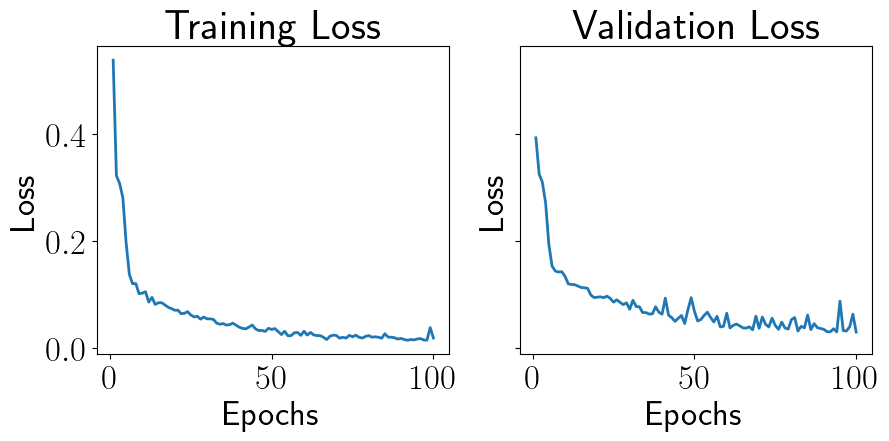

In [100]:
#plot training stats
training_stats = pd.DataFrame(training_stats)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(training_stats['epoch'], training_stats['Training Loss'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(training_stats['epoch'], training_stats['Validation Loss'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
plt.show()

[0.90582121 0.85103    0.86636635 0.86873104 0.88666436 0.88899428]


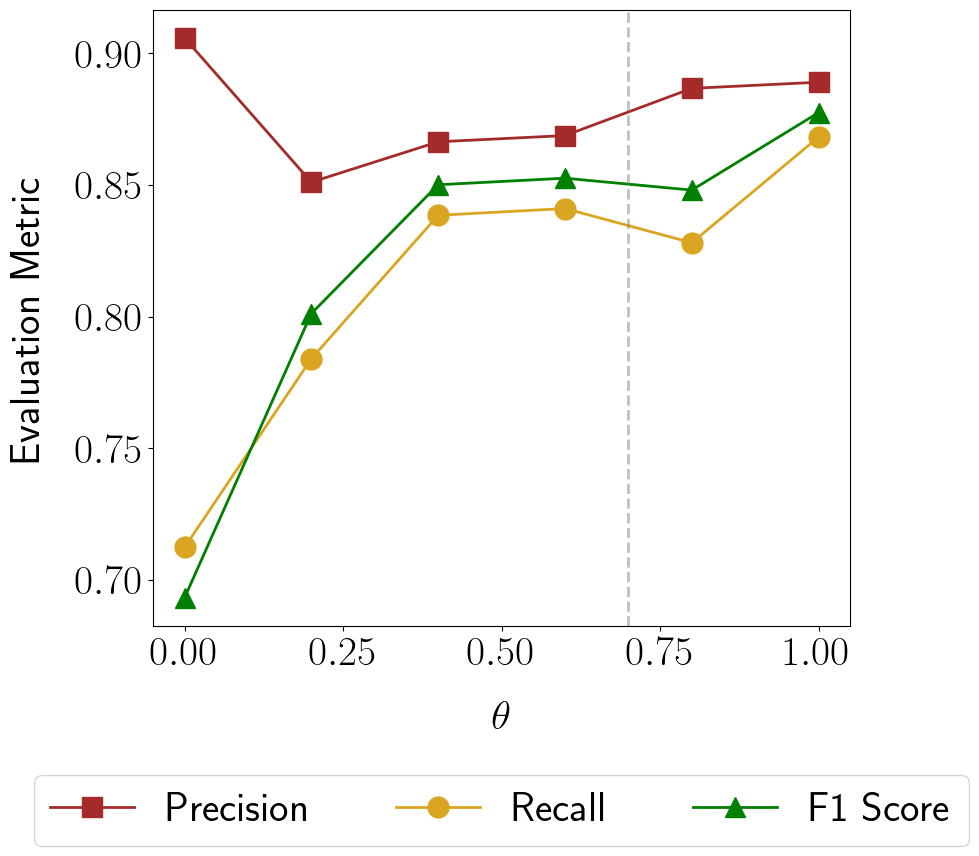

In [16]:
# you need to run 'scrpts/no_split.sh' for produce the hyperparameter finetuning plots.

thetas = np.round(0.2*np.arange(0, 6), 1)
colors = ['brown', 'goldenrod', 'green']

precisions = np.zeros(len(thetas))
recalls = np.zeros(len(thetas))
f1scores = np.zeros(len(thetas))

for i, theta in enumerate(thetas):
    dir = os.path.join(training_results_dir, f"theta{theta}")
    # dir = os.path.dirname(os.path.dirname(dir))
    precisions[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
    recalls[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
    f1scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)


print(precisions)

plt.figure(figsize=(9,8))
plt.plot(thetas, precisions, color=colors[0], label='Precision', markersize=15, linewidth=2, marker='s',)
plt.plot(thetas, recalls, color=colors[1], label='Recall', markersize=15, linewidth=2, marker='o',)
plt.plot(thetas, f1scores, color=colors[2], label='F1 Score', markersize=15, linewidth=2, marker='^',)
plt.axvline(0.7, color='grey', alpha=0.5, linestyle='--')
plt.xlabel(r'$\theta$', labelpad=20)
plt.ylabel('Evaluation Metric', labelpad=20)
plt.legend(loc='center', bbox_to_anchor=(.5, -0.3), ncol=3)
# plt.tight_layout()
plt.savefig('../figures/no_split-theta_tuning.pdf', format="pdf", bbox_inches="tight")
plt.show()

<Figure size 640x480 with 0 Axes>

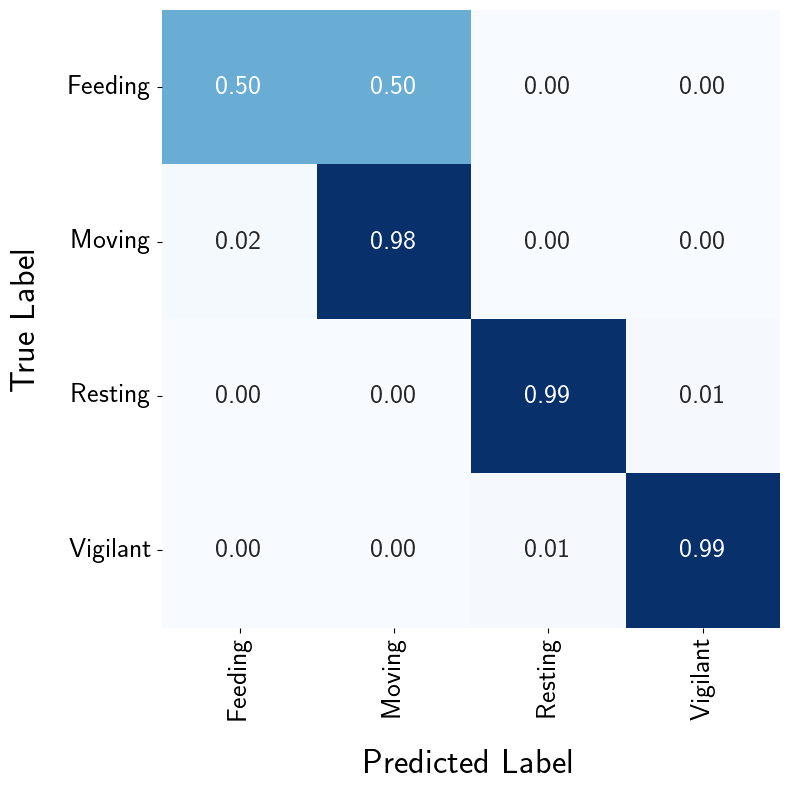

In [79]:
dir = os.path.join(training_results_dir, f"theta0.0")
y= np.load(os.path.join(dir, 'test_true_classes.npy'))
y_hat= np.load(os.path.join(dir, 'test_predictions.npy'))

multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

<Figure size 640x480 with 0 Axes>

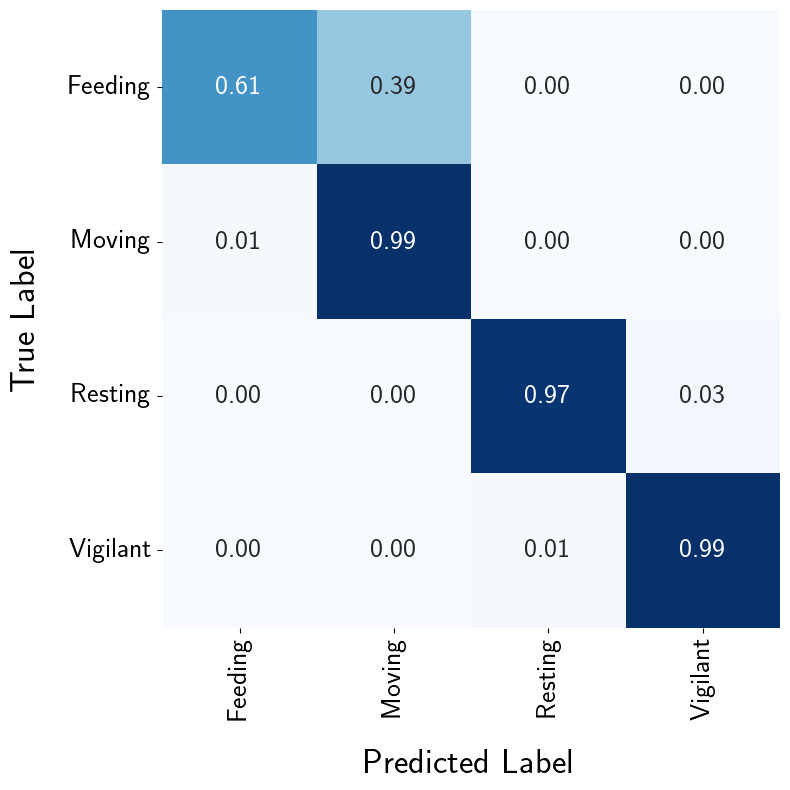

In [80]:
dir = os.path.join(training_results_dir, f"theta0.8")
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

## Result 1: Uncertainty Quantification

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


In [19]:
from src.methods.conformal_prediction import *
from src.utils.conformal import *

model_dir = os.path.join(training_results_dir, f"theta1.0")
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

if device == torch.device("cpu"):
    model = torch.load(os.path.join(model_dir, 'model.pt'), map_location=torch.device('cpu'))
else:
    model = torch.load(os.path.join(model_dir, 'model.pt'))

cdataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
cmodel = ConformalModel(model, cdataloader, alpha=0.05, randomized=True, lamda_criterion='size').to(device)
torch.save(cmodel, os.path.join(model_dir, 'cmodel.pt'))

/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/tmp/ipykernel_1665455/3761805829.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that cou

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 13/13 [00:00<00:00, 284.69it/s]


Optimal T=0.7794167399406433


In [20]:
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test)), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 999 | Avg Time: 0.003 | Avg Cvg@1: 0.924 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.963 | Avg Size@RAPS: 1.386



As an example, there are a total of 6 **feeding** labels that are incorrectly predicted as **moving** by the most-likely prediction. 

In [21]:
scores, psets = cmodel(torch.Tensor(X_test).float().to(device))
scores = scores.detach().cpu().numpy()
most_likely = np.argmax(scores, axis=1)
idx = np.where((y_test == 0) & (most_likely != y_test))[0]
for id in idx:
    print(f"{str(label_encoder.inverse_transform(psets[id])):<20} with scores {scores[id][list(psets[id])]}")

['Moving']           with scores [0.9987997]
['Moving' 'Feeding'] with scores [0.85495174 0.251357  ]
['Moving' 'Feeding'] with scores [0.9896672  0.01172565]
['Moving' 'Feeding'] with scores [0.73146147 0.35521987]
['Moving' 'Feeding'] with scores [0.49644396 0.48359793]
['Moving']           with scores [0.97174996]


In [22]:
print(f"{np.round(((1-no_split_test_top1) - (1-no_split_test_coverage)) / (1-no_split_test_top1), 5)}% of incorrectly predicted observations are in the RAPS.")

0.51316% of incorrectly predicted observations are in the RAPS.


In [23]:
for observed_behavior in config.SIM_BEHAVIORS:
    print(observed_behavior)
    label = label_encoder.transform([observed_behavior])
    mask = (y_test == label)
    ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
    no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

    

Feeding
N: 39 | Avg Time: 0.003 | Avg Cvg@1: 0.846 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.923 | Avg Size@RAPS: 1.538

Moving
N: 153 | Avg Time: 0.004 | Avg Cvg@1: 0.967 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.993 | Avg Size@RAPS: 1.314

Resting
N: 468 | Avg Time: 0.004 | Avg Cvg@1: 0.921 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.949 | Avg Size@RAPS: 1.389

Vigilant
N: 339 | Avg Time: 0.004 | Avg Cvg@1: 0.917 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.950 | Avg Size@RAPS: 1.401



In [24]:
test_scores = np.load(os.path.join(model_dir, 'test_scores.npy'))
mask = (np.max(test_scores, axis=1) < 0.9)

# test observations with high score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

# test observations with low score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[~mask], dtype=torch.float32), torch.tensor(y_test[~mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

N: 195 | Avg Time: 0.004 | Avg Cvg@1: 0.862 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.928 | Avg Size@RAPS: 1.544

N: 804 | Avg Time: 0.004 | Avg Cvg@1: 0.939 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 0.956 | Avg Size@RAPS: 1.356



#### Comparing the time spent in each behavior

/home/medhaaga/AWD-Biologging/notebooks/../src/utils/simulations.py:365: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


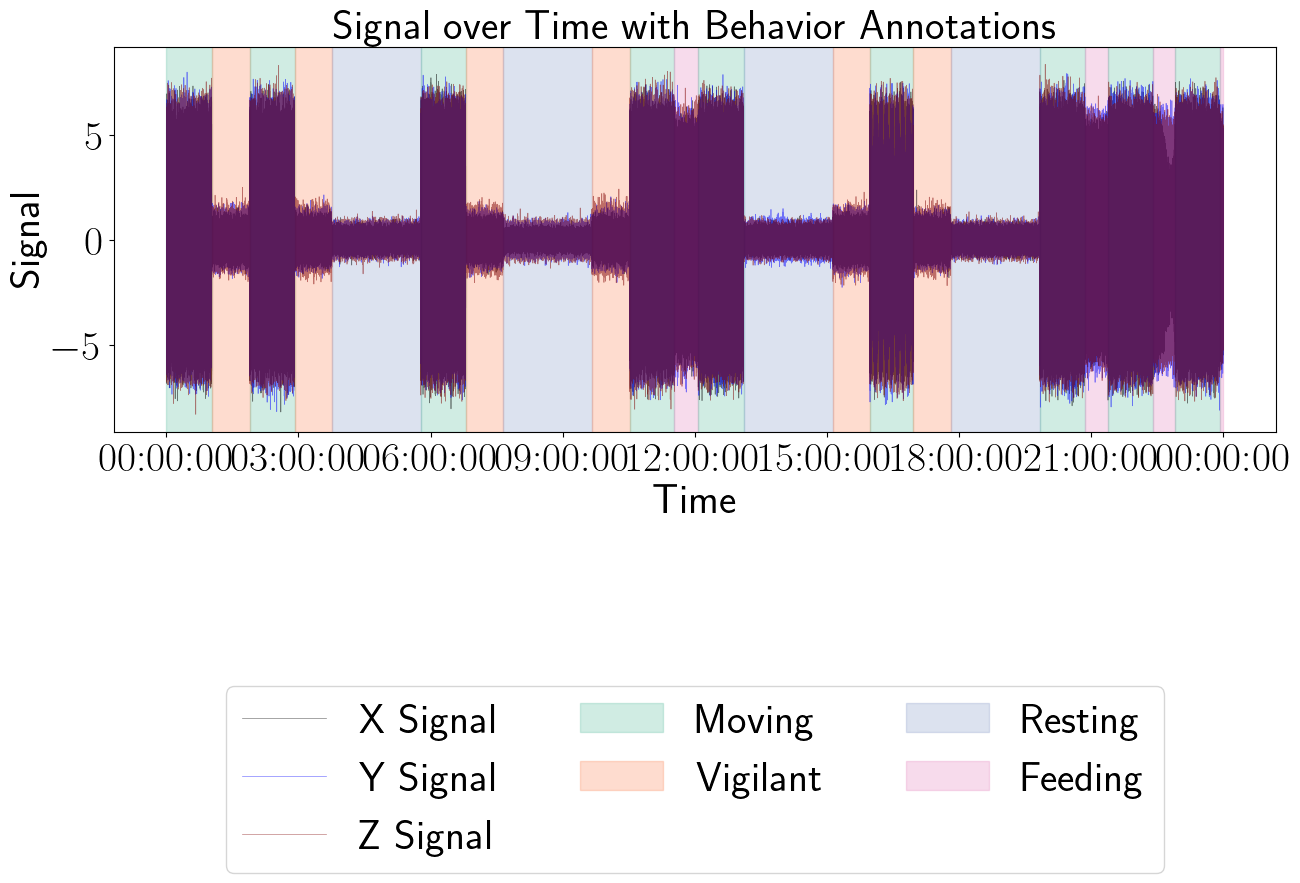

In [25]:
transition_matrix = np.array([
    [0.0, 0.7, 0.0, 0.3],  # from Feeding
    [0.4, 0.0, 0.2, 0.4],  # from Moving
    [0.0, 0.6, 0.0, 0.4],  # from Resting
    [0.0, 0.5, 0.5, 0.0],  # from Vigilant
])
avg_durations = {
    "Feeding": {"min": 30, "sec": 60},
    "Moving": {"min": 60, "sec": 60},
    "Resting": {"min": 120, "sec": 60},
    "Vigilant": {"min": 50, "sec": 60}
}
# Convert to DataFrame
avg_durations = pd.DataFrame.from_dict(avg_durations, orient="index")
avg_durations.index.name = "Behavior"
avg_durations.columns.name = "DurationUnit"

acc_df, annotations_df = simulate_markov_acc_day(config.SIMULATION_CONSTANTS, transition_matrix, avg_durations)
plot_simulated_day(acc_df)

The time spent in each behavior for a simulated 24 hours accelerationbehavior data is displayed below.

In [26]:
window_duration = 30.0
window_length = int(window_duration * config.SAMPLING_RATE)

acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }
scores = online_score_evaluation(model_dir=model_dir, 
                                X=signal, window_duration=window_duration, 
                                window_length=None, hop_length=smoothening_config['score_hop_length'], 
                                sampling_frequency=config.SAMPLING_RATE)

behavior_counts = acc_df['Behavior'].value_counts()
behavior_durations = (behavior_counts / config.SAMPLING_RATE)/3600

print("Time Spent in Each Behavior for the simulated data")
print(behavior_durations)

/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

Time Spent in Each Behavior for the simulated data
Behavior
Moving      9.186580
Resting     8.074306
Vigilant    5.099809
Feeding     1.638819
Name: count, dtype: float64


['Feeding']
['Feeding' 'Moving']


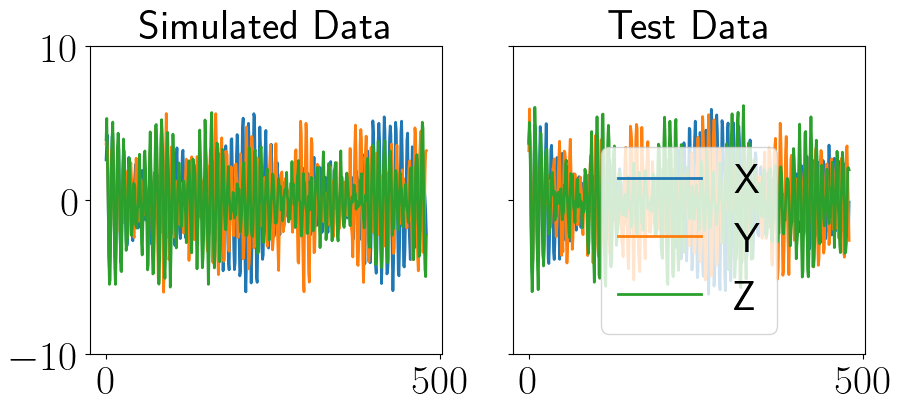

In [27]:
f_X, A_X, phi_X, sigma_X = data_constants.loc[(data_constants["Behavior"] == 'Feeding') & (data_constants["Axis"] == "X"), ['f', 'A', 'phi', 'sigma']].values[0]
f_Y, A_Y, phi_Y, sigma_Y = data_constants.loc[(data_constants["Behavior"] == 'Feeding') & (data_constants["Axis"] == "Y"), ['f', 'A', 'phi', 'sigma']].values[0]
f_Z, A_Z, phi_Z, sigma_Z = data_constants.loc[(data_constants["Behavior"] == 'Feeding') & (data_constants["Axis"] == "Z"), ['f', 'A', 'phi', 'sigma']].values[0]

signal_x = simulate_axis_signal(f_X, A_X, phi_X, sigma_X, window_length)
signal_y = simulate_axis_signal(f_Y, A_Y, phi_Y, sigma_Y, window_length)
signal_z = simulate_axis_signal(f_Z, A_Z, phi_Z, sigma_Z, window_length)


simulated_feeding_signal = np.stack([signal_x, signal_y, signal_z], axis=0)
simulated_feeding_signal = simulated_feeding_signal[np.newaxis, :, :]

fig, axs = plt.subplots(1, 2, figsize=(10,4), sharey=True)
axs[0].plot(np.arange(simulated_feeding_signal.shape[-1]), simulated_feeding_signal[0,0,:], label="X")
axs[0].plot(np.arange(simulated_feeding_signal.shape[-1]), simulated_feeding_signal[0,1,:], label="Y")
axs[0].plot(np.arange(simulated_feeding_signal.shape[-1]), simulated_feeding_signal[0,2,:], label="Z")
axs[0].set_ylim(-10,10)
axs[0].set_title("Simulated Data")
s, pset = cmodel(torch.tensor(simulated_feeding_signal).float().to(device))
print(label_encoder.inverse_transform(pset[0]))

feeding_idx = np.where(y_test == 0)[0]
feeding_X = X_test[feeding_idx[0], :, :]
feeding_X = torch.tensor(feeding_X).unsqueeze(0).float()
axs[1].plot(np.arange(feeding_X.shape[-1]), feeding_X[0,0,:], label="X")
axs[1].plot(np.arange(feeding_X.shape[-1]), feeding_X[0,1,:], label="Y")
axs[1].plot(np.arange(feeding_X.shape[-1]), feeding_X[0,2,:], label="Z")
axs[1].set_title("Test Data")
s, pset = cmodel(feeding_X.to(device))
print(label_encoder.inverse_transform(pset[0]))
plt.legend()
plt.show()

In [28]:
top1_behaviors = np.argmax(scores, axis=1)  # shape (1, B, W)
unique, counts = np.unique(top1_behaviors, return_counts=True)

total_top1_durations = dict(zip(label_encoder.inverse_transform(unique), np.round(counts *32/3600, 4)))
print("TOP-1 PREDICTION DURATIONS")
print(total_top1_durations)

TOP-1 PREDICTION DURATIONS
{'Feeding': 1.2711, 'Moving': 10.2578, 'Resting': 8.6133, 'Vigilant': 5.4489}


In [29]:
@dataclass
class BehaviorMetrics:
    duration: float
    count: int
    raps_cvg: int
    top1_cvg: int
        
total_raps_metrics = {behavior: BehaviorMetrics(duration=0.0, count=0, raps_cvg=0, top1_cvg=0) for behavior in config.SIM_BEHAVIORS}
multiple_behavior_count = 0
window_length = int(window_duration * config.SAMPLING_RATE)
hop_length = window_length

# check if model and window duration are compatible
cmodel = torch.load(os.path.join(model_dir, 'cmodel.pt')).to(device)

zero_signal = torch.zeros(1, 3, window_length).to(device)
assert cmodel.model[:-2](zero_signal).shape[-1] == cmodel.model[-2].in_features, "Window duration and model not compatible"

signal = signal[:, :, (signal.shape[2] - window_length) % hop_length : ]
signal_behaviors = acc_df['Behavior'][(signal.shape[2] - window_length) % hop_length : ].values
confusing_obs = []

for i in range(1 + (signal.shape[2] - window_length)//hop_length):
    X_temp = signal[:, :, i*hop_length : i*hop_length+window_length]
    X_temp_behaviors = signal_behaviors[i*hop_length : i*hop_length+window_length]
    
    with torch.no_grad():
        outputs, pset = cmodel(X_temp.to(device))
    pset = label_encoder.inverse_transform(pset[0])

    if len(list(pset)) > 1:
        confusing_obs.append({'signal': X_temp, 'pset': pset, 'true_behavior': X_temp_behaviors[0]})

    for b in list(pset):
        total_raps_metrics[b].duration += np.round(window_duration/3600, 4)

    if X_temp_behaviors[0] == X_temp_behaviors[-1]:
        window_behavior = X_temp_behaviors[0]
        total_raps_metrics[window_behavior].count += 1

        if window_behavior == label_encoder.inverse_transform([np.argmax(outputs.cpu().numpy())])[0]:
            total_raps_metrics[window_behavior].top1_cvg += 1

        if window_behavior in list(pset):
            total_raps_metrics[window_behavior].raps_cvg += 1
    else:
        multiple_behavior_count += 1
        window_behavior = X_temp_behaviors[-1]
        total_raps_metrics[window_behavior].count += 1

        if window_behavior == label_encoder.inverse_transform([np.argmax(outputs.cpu().numpy())])[0]:
            total_raps_metrics[window_behavior].top1_cvg += 1

        if window_behavior in list(pset):
            total_raps_metrics[window_behavior].raps_cvg += 1


raps_summary = pd.DataFrame.from_dict({k: (v.duration, np.round(v.raps_cvg/v.count, 4), np.round(v.top1_cvg/v.count, 4)) for k,v in total_raps_metrics.items()}, orient="index")
raps_summary.columns = ['Duration', 'RAPS Coverage', 'Top1 Coverage']
print("PREDICTION SET DURATIONS")
print(raps_summary)

/tmp/ipykernel_1665455/4099399822.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'cmodel.pt')).to(device)


PREDICTION SET DURATIONS
          Duration  RAPS Coverage  Top1 Coverage
Feeding     4.4073         0.9184         0.7245
Moving     10.2671         0.9991         0.9973
Resting    10.0430         0.9959         0.9959
Vigilant    8.3166         0.9951         0.9951


In [30]:
print(f"{'Number of windows with 2 true behaviors:':<45} {multiple_behavior_count}/{24*3600/30}")
print(f"{'Number of windows with RAPS size > 1:':<45} {len(confusing_obs)}/{24*3600/30}")


Number of windows with 2 true behaviors:      22/2880.0
Number of windows with RAPS size > 1:         1100/2880.0


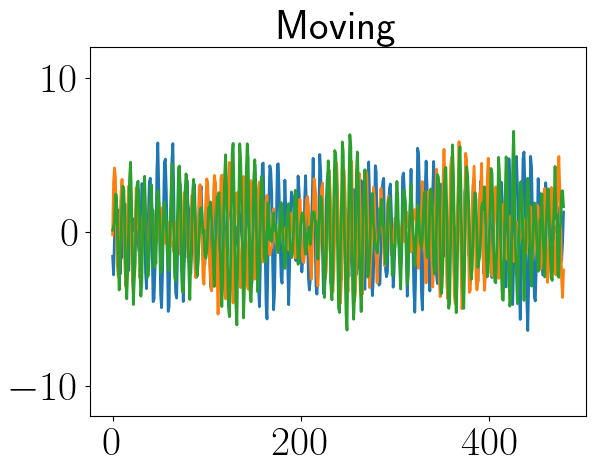

['Moving' 'Feeding']


In [31]:
idx = np.random.choice(len(confusing_obs))
obs = confusing_obs[idx]
window_length = int(window_duration*config.SAMPLING_RATE)
plt.plot(np.arange(window_length), obs['signal'][0,0,:])
plt.plot(np.arange(window_length), obs['signal'][0,1,:])
plt.plot(np.arange(window_length), obs['signal'][0,2,:])
plt.ylim(-12,12)
plt.title(obs['true_behavior'])
plt.show()
print(obs['pset'])

## Result 3: Temporal Context

/home/medhaaga/AWD-Biologging/notebooks/../src/utils/simulations.py:365: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


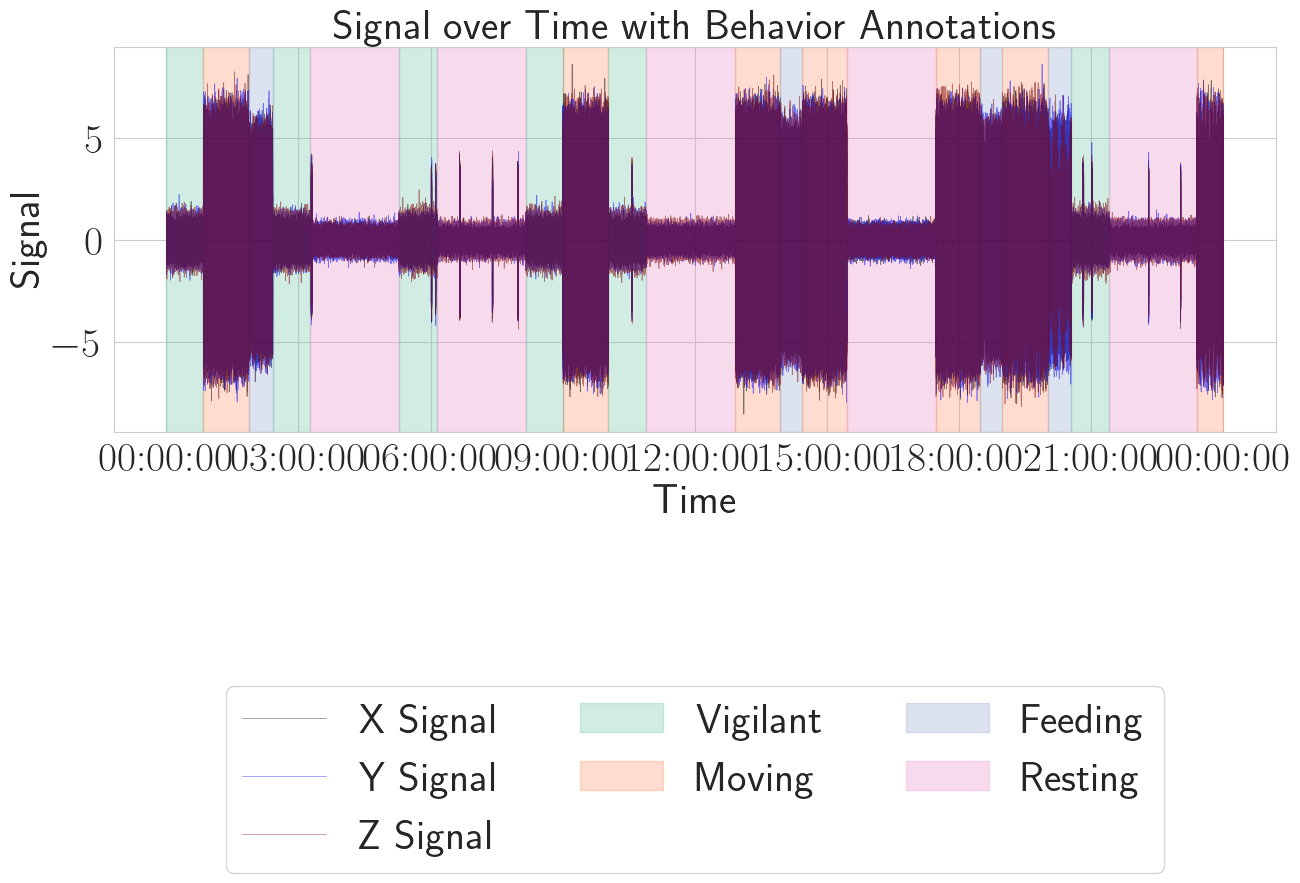

In [48]:
acc_df, annotations_df = simulate_markov_acc_day(config.SIMULATION_CONSTANTS, transition_matrix, avg_durations)
n_corruptions = 20
min_duration, max_duration = window_length, 3*window_length
pos = np.random.randint(0, len(acc_df)-max_duration, n_corruptions)
durations = np.random.randint(min_duration, max_duration, n_corruptions)

for p, d in zip(pos, durations):
    f, A, phi, sigma = [3,4], [2,1], [0.5,0.7], 0.5
    acc_df.loc[p:p+d-1, 'Acc X [g]'] = simulate_axis_signal(f, A, phi, sigma, d)
    acc_df.loc[p:p+d-1, 'Acc Y [g]'] = simulate_axis_signal(f, A, phi, sigma, d)
    acc_df.loc[p:p+d-1, 'Acc Z [g]'] = simulate_axis_signal(f, A, phi, sigma, d)

plot_simulated_day(acc_df)

In [49]:
acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)

In [50]:
label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)
all_day_behaviors = annotations_df
all_day_behaviors = all_day_behaviors.rename(columns={'Timestamp_start': 'behavior_start', 'Timestamp_end': 'behavior_end', 'Behavior': 'behavior'})

/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

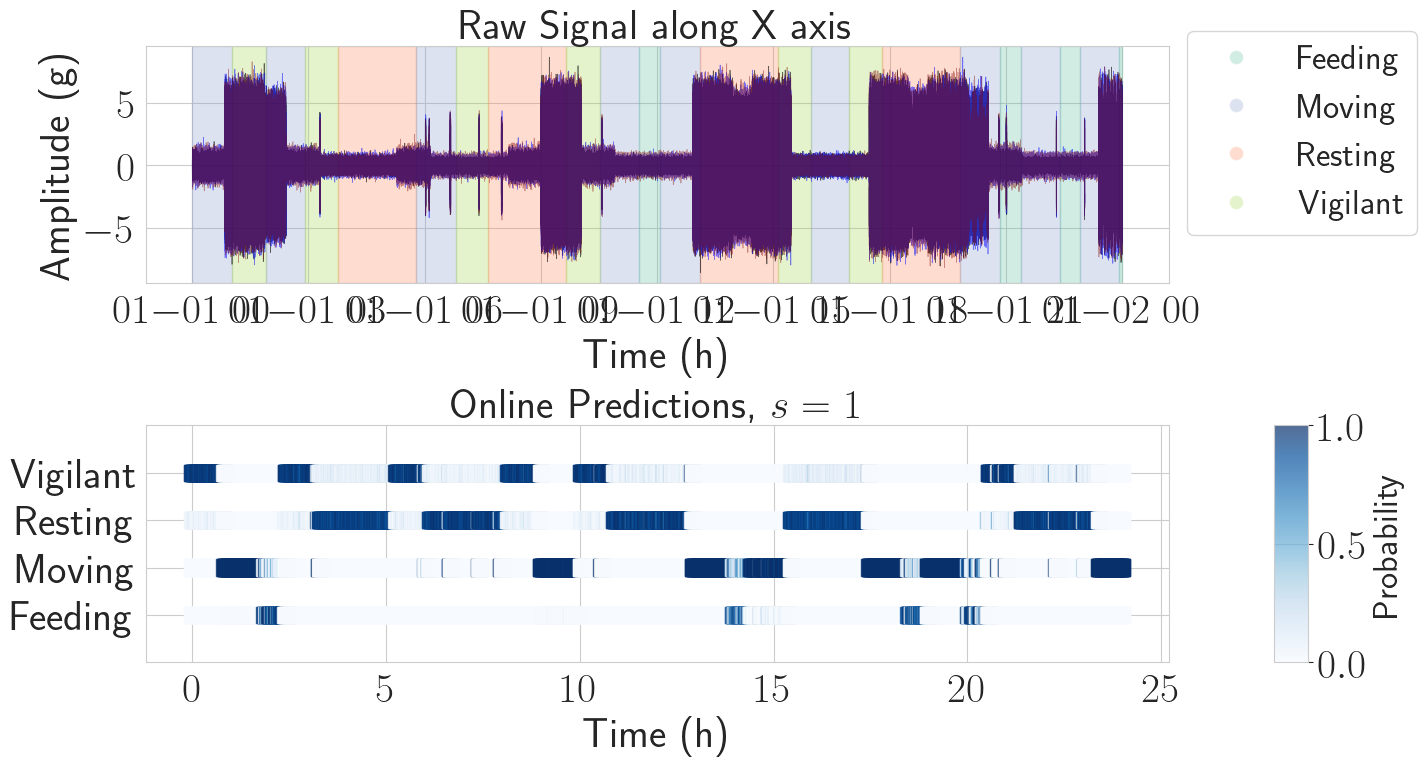

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 1$'}, xlabel='Time (h)'>))

In [51]:
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=None,
    half_day_behaviors=half_day_behaviors
)

/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

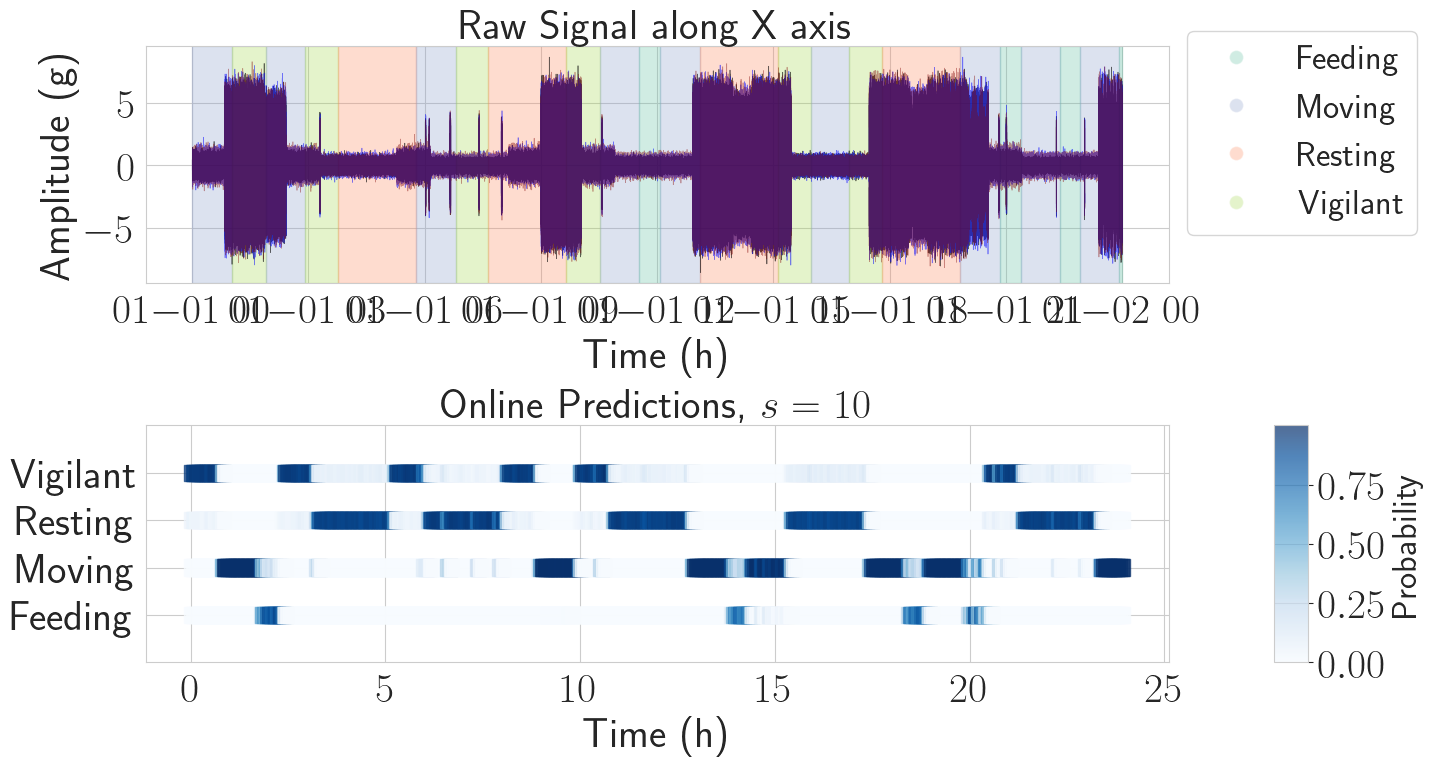

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 10$'}, xlabel='Time (h)'>))

In [52]:
smoothening_config = {'smoothening_window_length': 10,
                          'smoothening_hop_length': 5,
                          'score_hop_length': None
                          }
                          
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=None,
    half_day_behaviors=half_day_behaviors
)

## Result 4: Distribution Shift

In [11]:
from src.utils.simulations import generate_dataset, compute_features, energy_distance
from sklearn.model_selection import train_test_split
import ot
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import yaml

In [12]:
# experiment paths

results_dir = os.path.join(config.TEST_ROOT_DIR, "distribution_shift")
os.makedirs(results_dir, exist_ok=True)

# training results path
training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

# plots
plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

In [13]:
def get_test_data_constants(train_data_constants, eps):
    """
    Applies soft interpolation to f, A, and sigma values in train_data_constants
    based on behavior groups and returns a transformed copy.
    """
    # Define constants
    behaviors1_f, behaviors1_A, behaviors1_sigma = 1.5, 1.5, 1.0
    behaviors2_f, behaviors2_A, behaviors2_sigma = 0.2, 0.2, 0.2

    # Define transformation function
    transform_fn = lambda x, eps, x_hat: (1 - eps) * x + eps * x_hat

    df = train_data_constants.copy()

    # Mask for each group
    mask1 = df['Behavior'].isin(['Feeding', 'Moving'])
    mask2 = df['Behavior'].isin(['Resting', 'Vigilant'])

    # Apply transformation to each column and group
    for col, x_hat1, x_hat2 in [('f', behaviors1_f, behaviors2_f),
                                ('A', behaviors1_A, behaviors2_A)]:
        df.loc[mask1, col] = df.loc[mask1, col].apply(lambda tup: tuple(transform_fn(x, eps, x_hat1) for x in tup))
        df.loc[mask2, col] = df.loc[mask2, col].apply(lambda tup: tuple(transform_fn(x, eps, x_hat2) for x in tup))

    # Apply transformation to 'sigma'
    df.loc[mask1, 'sigma'] = df.loc[mask1, 'sigma'].apply(lambda x: transform_fn(x, eps, behaviors1_sigma))
    df.loc[mask2, 'sigma'] = df.loc[mask2, 'sigma'].apply(lambda x: transform_fn(x, eps, behaviors2_sigma))

    return df


In [14]:
train_data_constants = [
    
    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.4, 1.5, 1.7), (1.1, 1.2, 1.3), (0.2, 0.7, 1.2), 0.5),
    ("Feeding", "Y", (1.3, 1.5, 1.6), (1.1, 1.2, 1.4), (0.3, 0.8, 1.3), 0.6),
    ("Feeding", "Z", (1.5, 1.5, 1.8), (1.1, 1.2, 1.5), (0.4, 0.9, 1.4), 0.5),

    # Moving — bring down the amplitude and overlap with Moving
    ("Moving", "X", (1.4, 1.5, 1.7), (1.3, 1.5, 1.5), (0.2, 0.7, 1.2), 0.5),
    ("Moving", "Y", (1.3, 1.5, 1.6), (1.4, 1.5, 1.6), (0.3, 0.8, 1.3), 0.6),
    ("Moving", "Z", (1.5, 1.5, 1.8), (1.3, 1.4, 1.7), (0.4, 0.9, 1.4), 0.5),

    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.15),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), 0.2),

    # Vigilant — make it slightly jittery to overlap with Vigilant
    ("Vigilant", "X", (0.3, 0.4, 0.5), (0.2, 0.2, 0.15), (0.0, 0.1, 0.2), 0.15),
    ("Vigilant", "Y", (0.3, 0.4, 0.5), (0.2, 0.2, 0.15), (0.0, 0.1, 0.2), 0.2),
    ("Vigilant", "Z", (0.3, 0.4, 0.5), (0.2, 0.2, 0.15), (0.0, 0.1, 0.2), 0.2),
]

train_data_constants = pd.DataFrame(train_data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])
# train_data_constants = config.SIMULATION_CONSTANTS

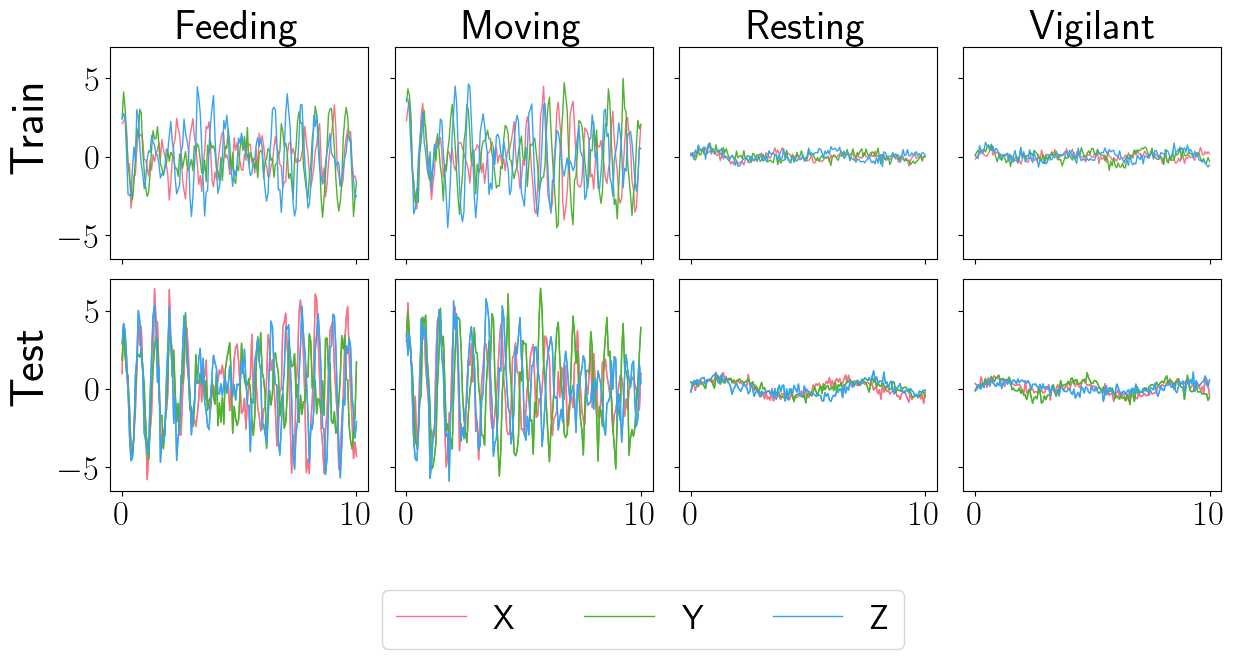

In [15]:
t = np.linspace(0, 10, 160)
fig, axs = plt.subplots(2, len(config.SIM_BEHAVIORS), figsize=(3*len(config.SIM_BEHAVIORS), 6), sharey=True, sharex=True)
color_palette = sns.color_palette("husl", 3)

test_data_constants = get_test_data_constants(train_data_constants, 1.0)

for i, observed_behavior in enumerate(config.SIM_BEHAVIORS):

    # Train 
    for j, axis in enumerate(['X', 'Y', 'Z']):

        f, A, phi, sigma = train_data_constants.loc[(train_data_constants["Behavior"] == observed_behavior) & (train_data_constants["Axis"] == axis), ['f', 'A', 'phi', 'sigma']].values[0]
        signal = simulate_axis_signal(list(f), list(A), list(phi), sigma, len(t)) #simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
        axs[0, i].plot(t, signal, color=color_palette[j], linewidth=1)

    axs[0, i].set_title(observed_behavior)

    # Test
    for j, axis in enumerate(['X', 'Y', 'Z']):

        f, A, phi, sigma = test_data_constants.loc[(test_data_constants["Behavior"] == observed_behavior) & (test_data_constants["Axis"] == axis), ['f', 'A', 'phi', 'sigma']].values[0]
        signal = simulate_axis_signal(list(f), list(A), list(phi), sigma, len(t)) #simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
        axs[1, i].plot(t, signal, color=color_palette[j], linewidth=1)

        if i == 0:
            axs[1, i].plot(t, signal, label=axis, color=color_palette[j], linewidth=1)
        else:
            axs[1, i].plot(t, signal, color=color_palette[j], linewidth=1)

fig.text(-0.01, 0.7, 'Train', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)
fig.text(-0.01, 0.3, 'Test', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space at the top for titles
plt.savefig(os.path.join(plots_dir, 'distribution_shift-raw_signals.pdf'))
plt.show()


In [16]:
train_class_dist = dict(zip(config.SIM_BEHAVIORS, [0.1, 0.4, 0.4, 0.1]))
test_class_dist = dict(zip(config.SIM_BEHAVIORS, [0.1, 0.4, 0.4, 0.1]))

window_length = int(30.0 * config.SAMPLING_RATE)
n_train, n_test = 5000, 5000

label_encoder = LabelEncoder()
label_encoder.fit(config.SIM_BEHAVIORS)

LabelEncoder()

In [17]:

@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=5, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=100, alpha=0.05, verbose=0
)

args.experiment_name = 'test_interyear'
args.theta= 0.8

train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles(args.experiment_name)

In [18]:
# train the CNN model on a fixed train set 

test_data_constants = get_test_data_constants(train_data_constants, 0.0)

# train and test set
X_train, y_train = generate_dataset(train_data_constants, train_class_dist, window_length, n_train, wrong_behavior=False, wrong_behavior_prob=0.4)
X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)

scaler = StandardScaler()
X_train_features = compute_features(X_train)
X_train_features = scaler.fit_transform(X_train_features)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(y_train))
y_train, y_val, y_test = label_encoder.transform(y_train), label_encoder.transform(y_val), label_encoder.transform(y_test)

train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                        num_conv_layers=args.n_CNNlayers, 
                                        base_channels=args.n_channels, 
                                        kernel_size=args.kernel_size).to(device)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

#### Training
train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
model = train_obj['model']
training_stats = train_obj['training_stats']

model_dir = training_results_dir
os.makedirs(model_dir, exist_ok=True)

torch.save(model, os.path.join(model_dir, 'model.pt'))
json_training_stats_file = os.path.join(model_dir, 'training_stats.json')
with open(json_training_stats_file, 'w') as f:
    json.dump(training_stats, f)

# save true and predicted validation classes along with val metadata
np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])


/home/medhaaga/miniconda3/envs/wildlife/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at /opt/conda/conda-bld/pytorch_1729647348947/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Epoch 100/100 | Train Loss: 0.0165 | Val Loss: 0.0435: 100%|██████████| 100/100 [02:36<00:00,  1.56s/it]

Total training time: 0:02:36


In [19]:
eps_list = np.round(np.linspace(0, 1, 11), 1)
exp_results = {'ot': np.zeros(len(eps_list)),
               'energy': np.zeros(len(eps_list)),
               'precision': np.zeros(len(eps_list)),
               'recall': np.zeros(len(eps_list)),
               'f1_score': np.zeros(len(eps_list))}
               
for i, eps in enumerate(eps_list):

    test_data_constants = get_test_data_constants(train_data_constants=train_data_constants, eps=eps)
    X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)
    
    X_test_features = compute_features(X_test)
    X_test_features = scaler.transform(X_test_features)

    ot_value = np.round(ot.sliced_wasserstein_distance(X_train_features, X_test_features, n_projections=100), 4)
    energy_value = np.round(energy_distance(X_train_features, X_test_features), 4)
    exp_results['ot'][i] = ot_value
    exp_results['energy'][i] = energy_value
    print(f"{'eps:':<5} {eps} | {'OT distance:':<10} {ot_value} | {'Energy distance:':<15} {energy_value}")


    train_test_dist = {'ot': ot_value,
                        'energy': energy_value}

    y_test = label_encoder.transform(y_test)
    model_dir = os.path.join(training_results_dir, f'eps{eps}')
    os.makedirs(model_dir, exist_ok=True)

    outputs = model(torch.Tensor(X_test).to(device))
    predictions_test = torch.argmax(outputs, dim=1).cpu().numpy()

    # save true and predicted test classes 
    np.save(os.path.join(model_dir, 'test_true_classes.npy'), y_test)
    np.save(os.path.join(model_dir, 'test_predictions.npy'),  predictions_test)

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(model_dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(model_dir, 'val_predictions.npy'),  train_obj['val_predictions'])

    with open(os.path.join(model_dir, 'train_test_dist.yaml'), 'w') as f:
        yaml.dump(train_test_dist, f)

    exp_results['precision'][i] = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 4)
    exp_results['recall'][i] = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 4)
    exp_results['f1_score'][i] = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 4)   

eps:  0.0 | OT distance: 0.0418 | Energy distance: 0.0047
eps:  0.1 | OT distance: 0.0593 | Energy distance: 0.008
eps:  0.2 | OT distance: 0.0871 | Energy distance: 0.0241
eps:  0.3 | OT distance: 0.1259 | Energy distance: 0.052
eps:  0.4 | OT distance: 0.1636 | Energy distance: 0.0936
eps:  0.5 | OT distance: 0.213 | Energy distance: 0.1359
eps:  0.6 | OT distance: 0.2412 | Energy distance: 0.2051
eps:  0.7 | OT distance: 0.291 | Energy distance: 0.2756
eps:  0.8 | OT distance: 0.3521 | Energy distance: 0.3679
eps:  0.9 | OT distance: 0.4132 | Energy distance: 0.4832
eps:  1.0 | OT distance: 0.474 | Energy distance: 0.6103


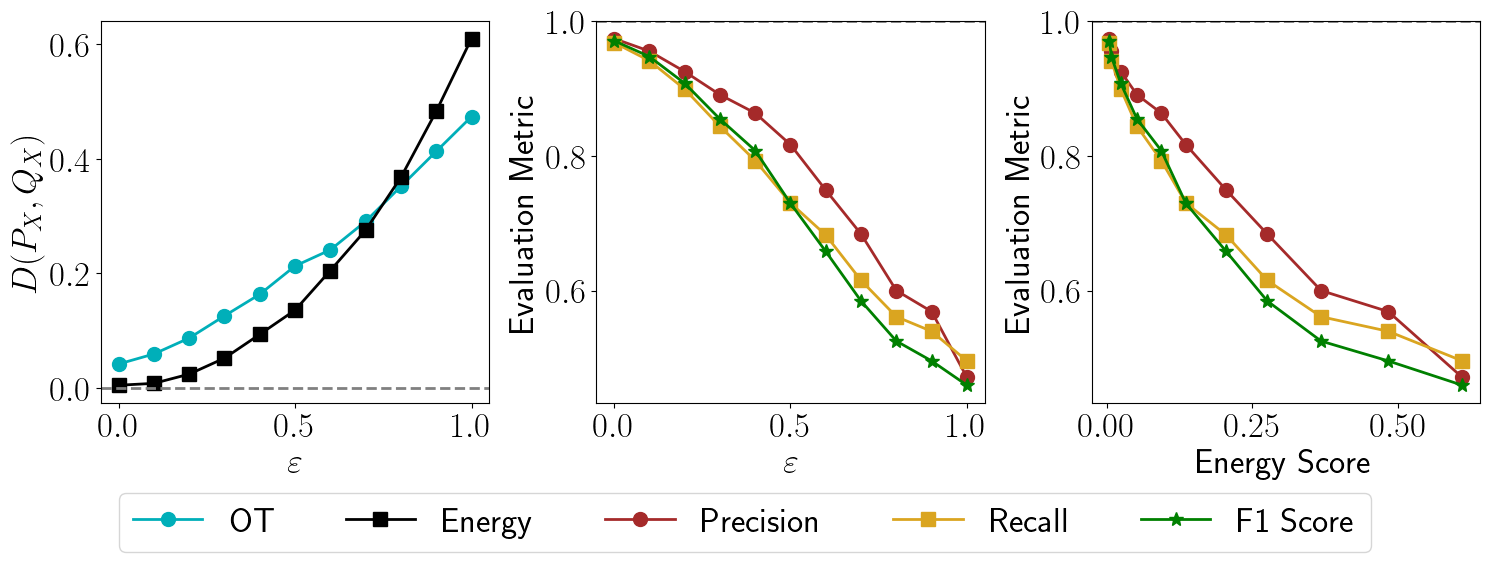

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))

axs[0].plot(eps_list, exp_results['ot'], marker = 'o', color='#00afb9', markersize=10, label='OT')
axs[0].plot(eps_list, exp_results['energy'], marker = 's', color='black', markersize=10, label='Energy')
axs[0].axhline(y=0.0, color='grey', linestyle='--')
axs[0].set_xlabel(r"$\varepsilon$")
axs[0].set_ylabel(r"$D(P_X, Q_X)$")

axs[1].plot(eps_list, exp_results['precision'], marker = 'o', color='brown', markersize=10, label='Precision')
axs[1].plot(eps_list, exp_results['recall'], marker = 's', color='goldenrod', markersize=10, label = 'Recall')
axs[1].plot(eps_list, exp_results['f1_score'], marker = '*', color='green', markersize=10, label='F1 Score')
axs[1].set_xlabel(r"$\varepsilon$")
axs[1].set_ylabel("Evaluation Metric")
axs[1].axhline(y=1.0, color='grey', linestyle='--')

axs[2].plot(exp_results['energy'], exp_results['precision'], marker = 'o', color='brown', markersize=10)
axs[2].plot(exp_results['energy'], exp_results['recall'], marker = 's', color='goldenrod', markersize=10)
axs[2].plot(exp_results['energy'], exp_results['f1_score'], marker = '*', color='green', markersize=10)
axs[2].set_xlabel("Energy Score")
axs[2].set_ylabel("Evaluation Metric")
axs[2].axhline(y=1.0, color='grey', linestyle='--')

# Create a common legend
handles, labels = [], []
for ax in axs:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.15), bbox_transform=fig.transFigure)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'distribution_shift-performance_decay.pdf'), bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

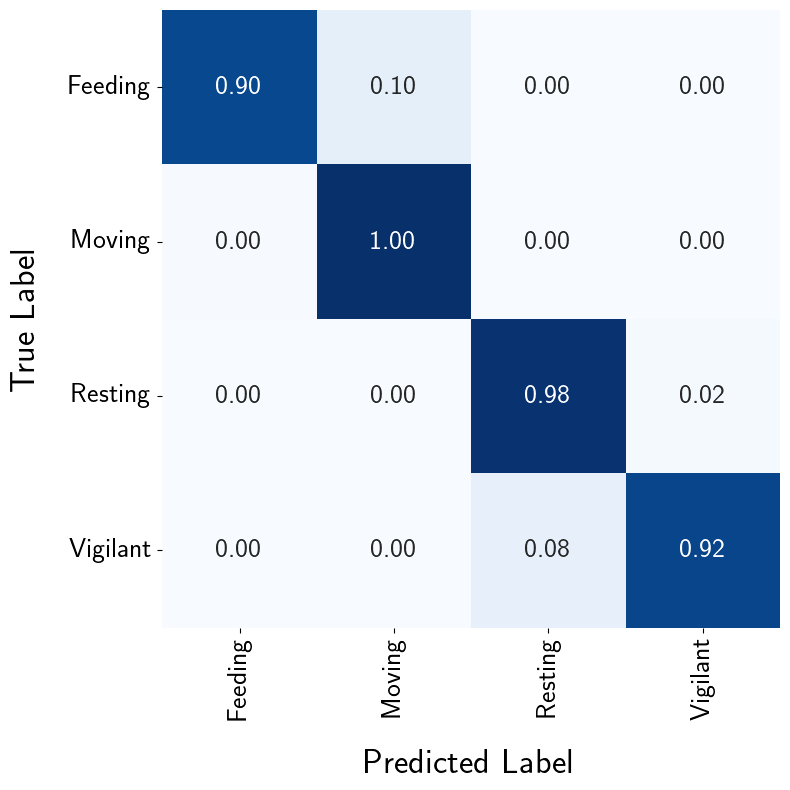

In [21]:
eps=0.0
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='val', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-val_confusion.pdf'))

<Figure size 640x480 with 0 Axes>

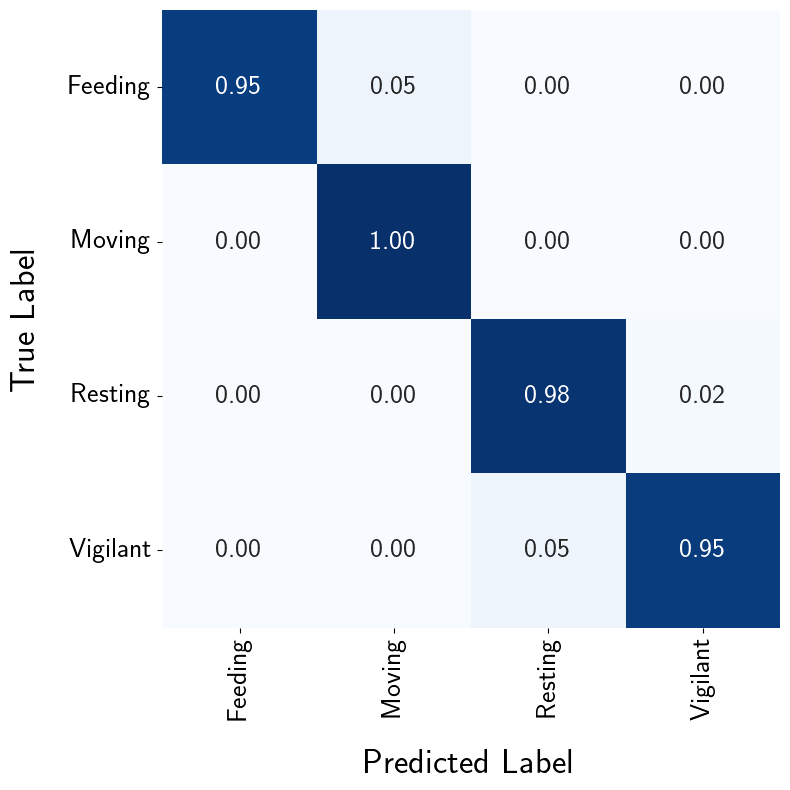

In [22]:
eps=0.0
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='test', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-test_confusion_eps0.1.pdf'))

<Figure size 640x480 with 0 Axes>

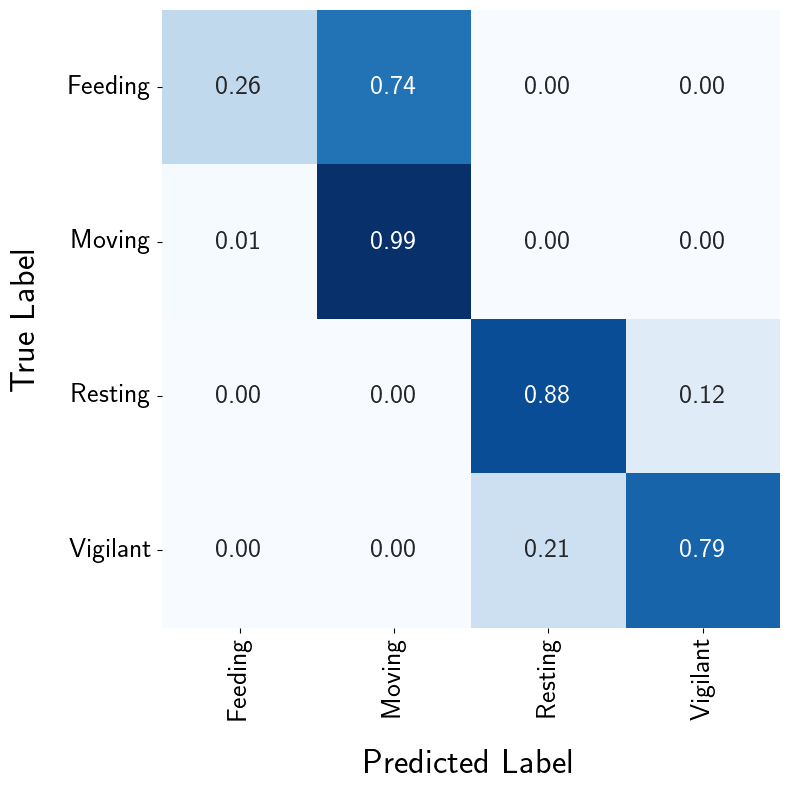

In [23]:
eps=0.5
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='test', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-test_confusion_eps0.5.pdf'))

<Figure size 640x480 with 0 Axes>

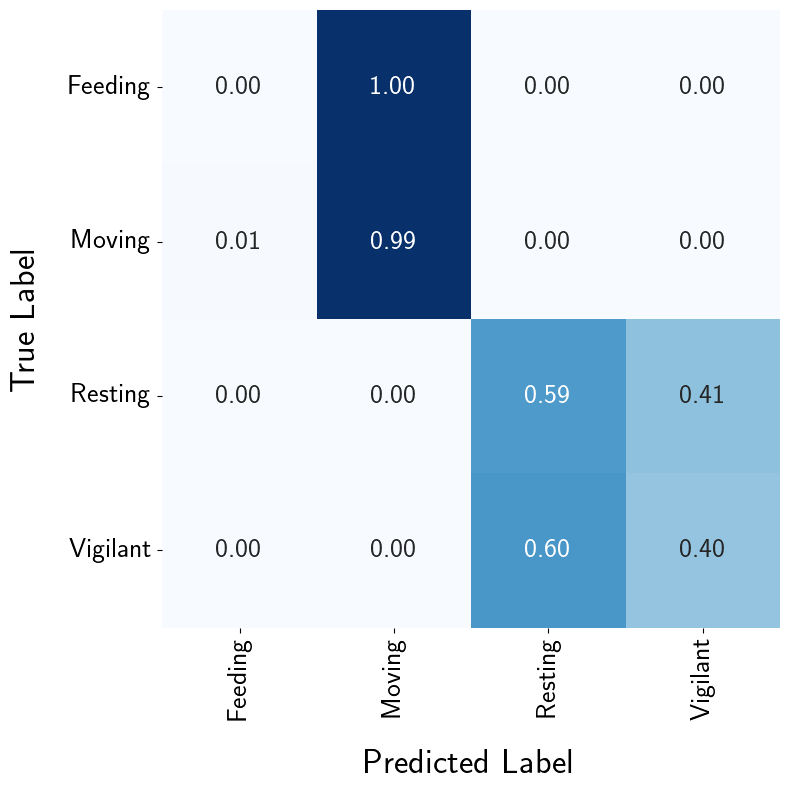

In [24]:
eps=1.0
model_dir = os.path.join(training_results_dir, f"eps{eps}")
multi_label_predictions(model_dir, 
                        label_encoder, 
                        split='test', 
                        plot_confusion=True, 
                        return_accuracy=False, 
                        plot_path=os.path.join(plots_dir, 'distribution_shift-test_confusion_eps1.0.pdf'))

In [134]:
print("VALIDATION SET")
print("")

print('VAL PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'precision': np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average=None), 3)}))

print('VAL RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'recall': np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average=None), 3)}))

print('VAL F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'f1 score': np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average=None), 3)}))

print('VAL ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(model_dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

VALIDATION SET

VAL PRECISION SCORE
---------------------
Average precision: 0.939
   behavior  precision
0   Feeding      1.000
1    Moving      0.967
2   Resting      0.972
3  Vigilant      0.818
VAL RECALL SCORE
---------------------
Average recall: 0.922
   behavior  recall
0   Feeding   0.878
1    Moving   1.000
2   Resting   0.967
3  Vigilant   0.844
VAL F1 SCORE
---------------------
Average F1 score: 0.93
   behavior  f1 score
0   Feeding     0.935
1    Moving     0.983
2   Resting     0.969
3  Vigilant     0.831
VAL ACCURACY
---------------------
Accuracy: 0.96


In [218]:
print("TEST SET")
print("")


print('TEST PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'precision': np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average=None), 3)}))

print('TEST RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'recall': np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average=None), 3)}))

print('TEST F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': config.SIM_BEHAVIORS, 'f1 score': np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average=None), 3)}))

print('TEST ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(model_dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

TEST SET

TEST PRECISION SCORE
---------------------
Average precision: 0.873
   behavior  precision
0   Feeding      0.880
1    Moving      0.935
2   Resting      0.925
3  Vigilant      0.750
TEST RECALL SCORE
---------------------
Average recall: 0.682
   behavior  recall
0   Feeding   0.611
1    Moving   0.985
2   Resting   0.996
3  Vigilant   0.136
TEST F1 SCORE
---------------------
Average F1 score: 0.718
   behavior  f1 score
0   Feeding     0.721
1    Moving     0.960
2   Resting     0.959
3  Vigilant     0.231
TEST ACCURACY
---------------------
Accuracy: 0.926


In [59]:
n_train, n_test = 5000, 5000
X_train, y_train = generate_dataset(train_data_constants, train_class_dist, window_length, n_train)
scaler = StandardScaler()
X_train_features = compute_features(X_train)
X_train_features = pd.DataFrame(scaler.fit_transform(X_train_features), columns=X_train_features.columns, index=X_train_features.index)

In [72]:
eps = 0.1
test_data_constants = get_test_data_constants(train_data_constants=train_data_constants, eps=eps)
X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)
X_test_features = compute_features(X_test)
X_test_features = pd.DataFrame(scaler.transform(X_test_features), columns=X_test_features.columns, index=X_test_features.index)

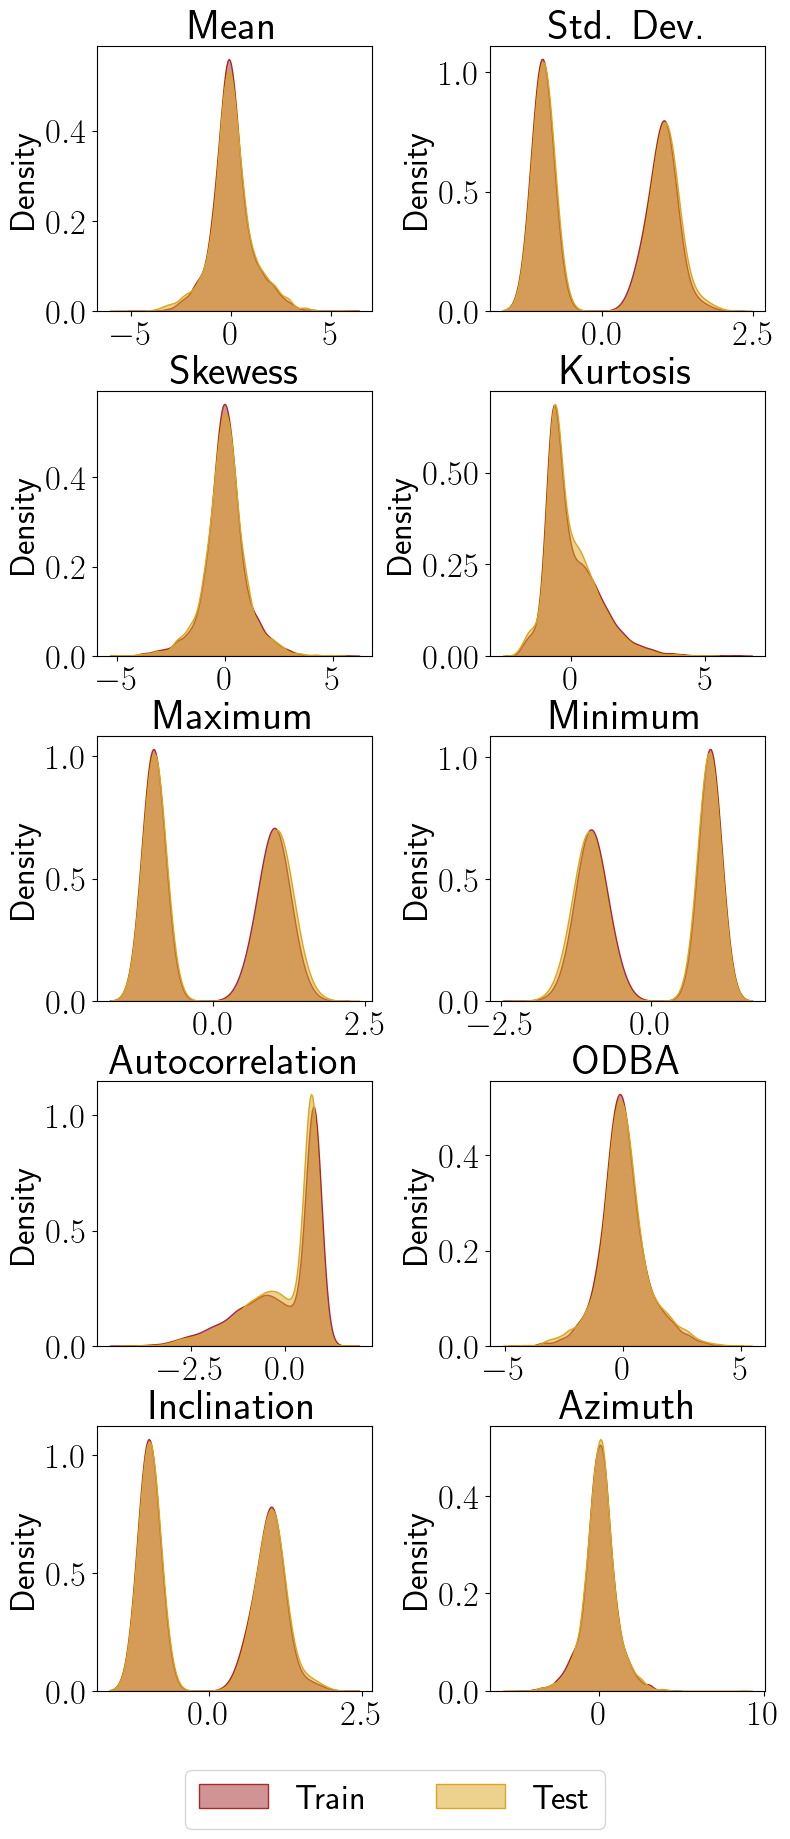

In [73]:
plot_cols = ['q_mean','q_std', 'q_skew', 'q_kurtosis', 'q_max', 
             'q_min', 'q_autocorr', 'odba', 'inclination_circvar', 'azimuth_circvar']

col_names = ['Mean', 'Std. Dev.', 'Skewess', 'Kurtosis', 'Maximum', 'Minimum', 
             'Autocorrelation', 'ODBA', 'Inclination', 'Azimuth']

fig, axes = plt.subplots(5, 2, figsize=(8, 20))

# Loop over each feature (marginal) and plot the KDE for both datasets
for i, c in enumerate(plot_cols):
    ax = axes[i//2, i%2]
    if i == 0:
        sns.kdeplot(X_train_features.iloc[:, i].values, ax=ax, label="Train", color="brown", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features.iloc[:, i].values, ax=ax, label="Test", color="goldenrod", fill=True, alpha=0.5)
    else:
        sns.kdeplot(X_train_features.iloc[:, i].values, ax=ax,  color="brown", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features.iloc[:, i].values, ax=ax, color="goldenrod", fill=True, alpha=0.5) 
    ax.set_title(col_names[i])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show the plot
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.show()

In [74]:
eps = 0.5
test_data_constants = get_test_data_constants(train_data_constants=train_data_constants, eps=eps)
X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)
X_test_features = compute_features(X_test)
X_test_features = pd.DataFrame(scaler.transform(X_test_features), columns=X_test_features.columns, index=X_test_features.index)

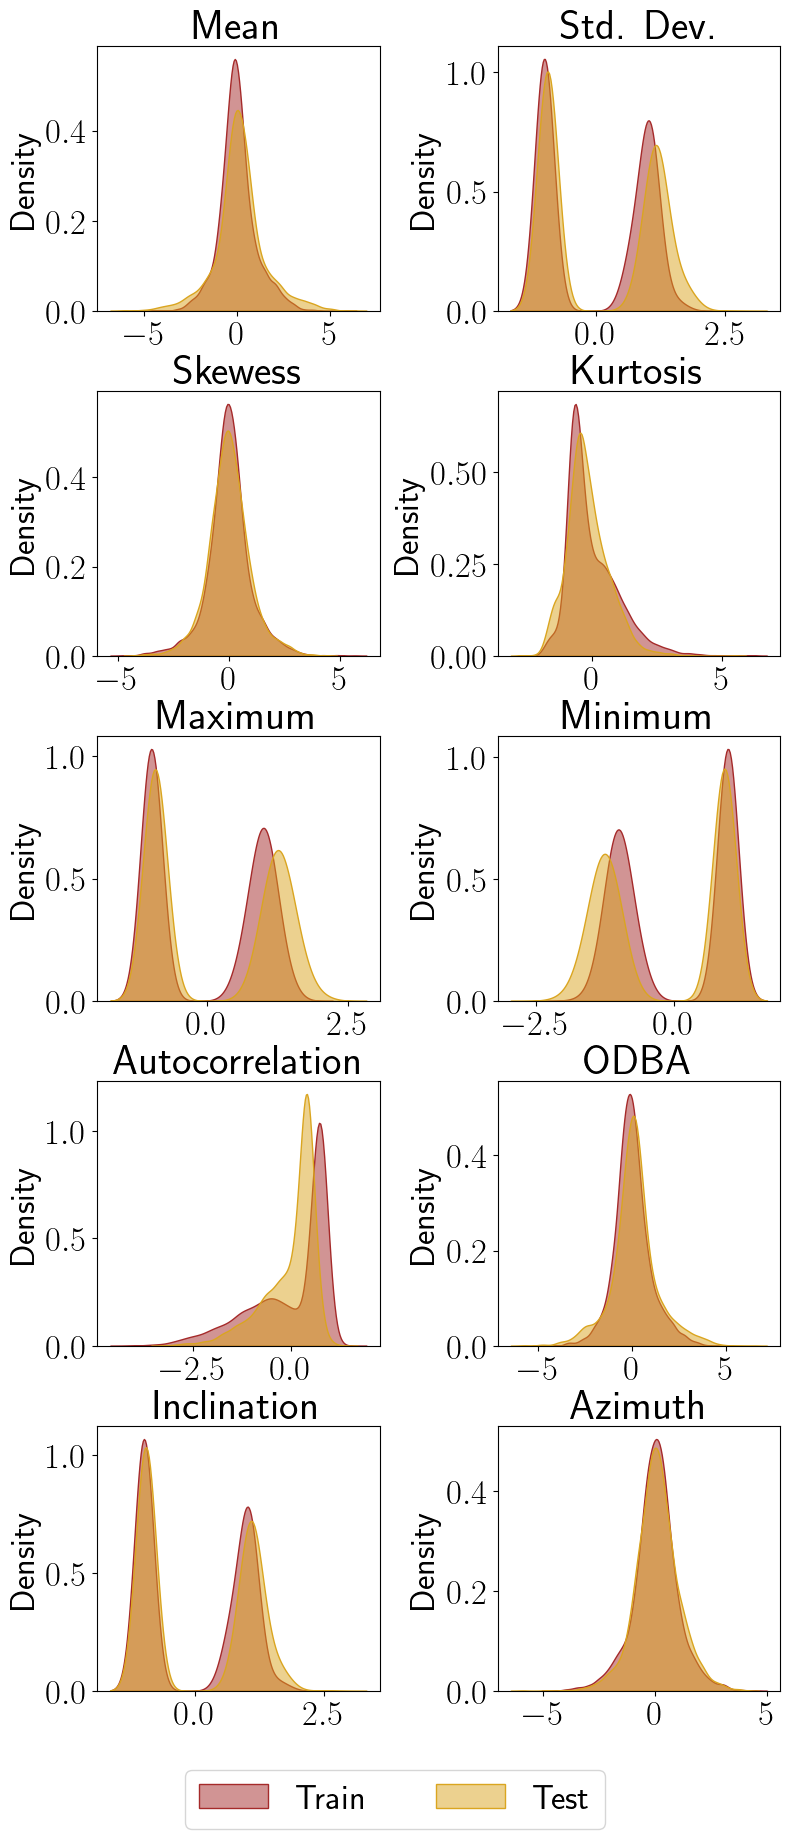

In [76]:
plot_cols = ['q_mean','q_std', 'q_skew', 'q_kurtosis', 'q_max', 
             'q_min', 'q_autocorr', 'odba', 'inclination_circvar', 'azimuth_circvar']

col_names = ['Mean', 'Std. Dev.', 'Skewess', 'Kurtosis', 'Maximum', 'Minimum', 
             'Autocorrelation', 'ODBA', 'Inclination', 'Azimuth']

fig, axes = plt.subplots(5, 2, figsize=(8, 20))

# Loop over each feature (marginal) and plot the KDE for both datasets
for i, c in enumerate(plot_cols):
    ax = axes[i//2, i%2]
    if i == 0:
        sns.kdeplot(X_train_features.iloc[:, i].values, ax=ax, label="Train", color="brown", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features.iloc[:, i].values, ax=ax, label="Test", color="goldenrod", fill=True, alpha=0.5)
    else:
        sns.kdeplot(X_train_features.iloc[:, i].values, ax=ax,  color="brown", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features.iloc[:, i].values, ax=ax, color="goldenrod", fill=True, alpha=0.5) 
    ax.set_title(col_names[i])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show the plot
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.show()

In [77]:
eps = 1.0
test_data_constants = get_test_data_constants(train_data_constants=train_data_constants, eps=eps)
X_test, y_test = generate_dataset(test_data_constants, test_class_dist, window_length, n_test)
X_test_features = compute_features(X_test)
X_test_features = pd.DataFrame(scaler.transform(X_test_features), columns=X_test_features.columns, index=X_test_features.index)

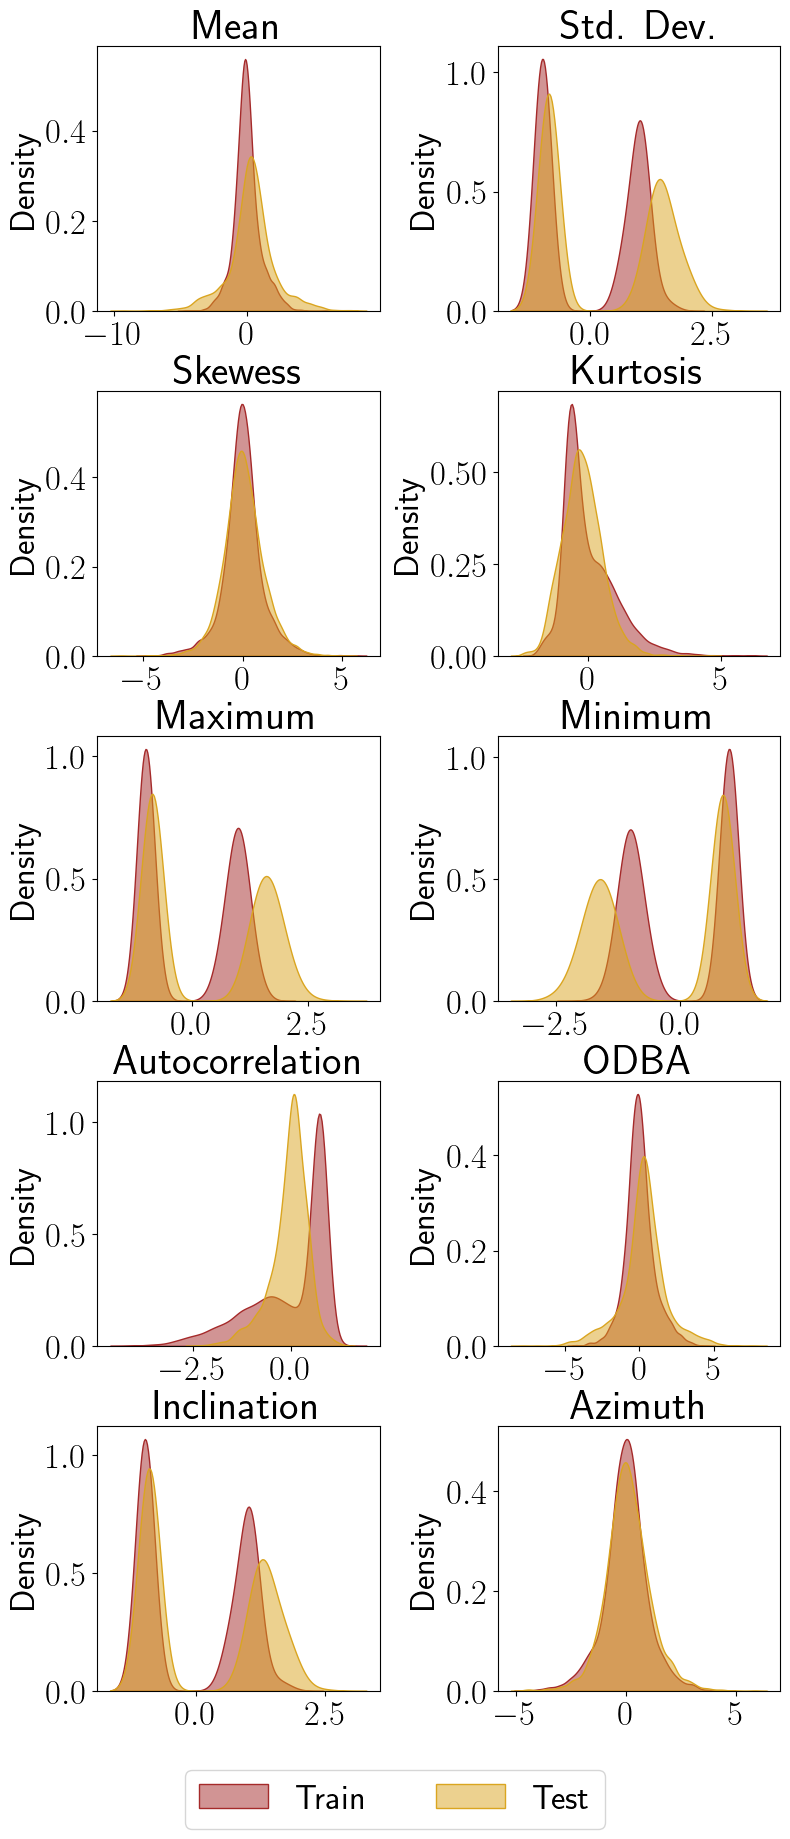

In [78]:
plot_cols = ['q_mean','q_std', 'q_skew', 'q_kurtosis', 'q_max', 
             'q_min', 'q_autocorr', 'odba', 'inclination_circvar', 'azimuth_circvar']

col_names = ['Mean', 'Std. Dev.', 'Skewess', 'Kurtosis', 'Maximum', 'Minimum', 
             'Autocorrelation', 'ODBA', 'Inclination', 'Azimuth']

fig, axes = plt.subplots(5, 2, figsize=(8, 20))

# Loop over each feature (marginal) and plot the KDE for both datasets
for i, c in enumerate(plot_cols):
    ax = axes[i//2, i%2]
    if i == 0:
        sns.kdeplot(X_train_features.iloc[:, i].values, ax=ax, label="Train", color="brown", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features.iloc[:, i].values, ax=ax, label="Test", color="goldenrod", fill=True, alpha=0.5)
    else:
        sns.kdeplot(X_train_features.iloc[:, i].values, ax=ax,  color="brown", fill=True, alpha=0.5)
        sns.kdeplot(X_test_features.iloc[:, i].values, ax=ax, color="goldenrod", fill=True, alpha=0.5) 
    ax.set_title(col_names[i])

plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show the plot
fig.legend(loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))
plt.show()